# Multi-Class Image for American Sign Language 🤙
## 1. Problem

identifying the image of American sign language.

## 2. Data

the data we're using is from kaggle's ASL_Alphabet_Dataset.

https://www.kaggle.com/datasets/debashishsau/aslamerican-sign-language-aplhabet-dataset

## 3. Evaluation

....fill it latter

## 4. Features

....fill it latter

In [9]:
# Unzip the uploaded data into google drive
!unzip -u 'drive/MyDrive/dataset/sign_language_dataset.zip' -d 'drive/MyDrive/dataset/'

Streaming output truncated to the last 5000 lines.
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2863).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2864).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2865).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2866).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2867).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2868).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2869).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (287).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space (2870).jpg  
  inflating: drive/MyDrive/dataset/ASL_Alphabet_Da

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get our workspace ready

* importing TensorFlow 2.x ✅
* importing TensorFlow hub ✅
* make sure we're using GPU ✅

## Importing the Library 📚

In [2]:
# Importing the TensorFlow into Colab
# importing necessary tools
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os
import datetime
import glob
import seaborn as sns
#import IPython
#!pip install -U Ipython
import tf_keras as tfk
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.layers import Dense
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.callbacks import Callback, EarlyStopping

In [3]:
# check for library version
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

# check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

TF version: 2.17.0
Hub version: 0.16.1
GPU available


## Loading the data

In [3]:
path_train = 'drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train'
path_test = '/content/drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_test'

In [4]:
# take all images from folders
train_path_list = list(glob.glob(path_train+'/**/*.jpg'))
test_path_list = list(glob.glob(path_test+'/*.jpg'))

In [5]:
def prepare_data_labels_and_paths(file_path):
    """
    Prepares a DataFrame containing image file paths and their corresponding labels.
    Args:
        file_path (list[str]): A list of file paths to the image files.

    Returns:
        pandas.DataFrame: A DataFrame with two columns: 'FilePath' containing the file paths and 'Label' containing the corresponding labels.

    Raises:
        ValueError: If the input `file_path` is not a list of strings.

    Example:
        ```python
        import os

        file_path = [
            "path/to/image1.jpg",
            "path/to/image2.jpg",
            "path/to/image3.jpg"
        ]

        df = prepare_data_labels_and_paths(file_path)
        print(df)
        ```
    """
    if not isinstance(file_path, list) or not all(isinstance(path, str) for path in file_path):
        raise ValueError("`file_path` must be a list of strings.")
    labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1].lower(), file_path))
    filepath = pd.Series(file_path, name='FilePath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [6]:
data_for_training = prepare_data_labels_and_paths(train_path_list)
data_for_training.head()

,FilePath,Label
0,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,y
1,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,c
2,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,j
3,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,nothing
4,drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl...,z


In [7]:
len(data_for_training)

217523

In [8]:
# Find the unique label values
unique_sign = np.unique(data_for_training['Label'])
len(unique_sign),unique_sign

(29,
 array(['a', 'b', 'c', 'd', 'del', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
        'm', 'n', 'nothing', 'o', 'p', 'q', 'r', 's', 'space', 't', 'u',
        'v', 'w', 'x', 'y', 'z'], dtype=object))

## Visualizing our Data 📊

In [9]:
def display_images_in_subplots(data, nrows=3, ncols=4, figsize=(10, 7)):
  """
  Displays a grid of images from the provided data in Matplotlib subplots.

  Args:
      data (pandas.DataFrame or similar): A DataFrame-like object containing two columns:
          - 'FilePath': A list of file paths to the images to be displayed.
          - 'Label': A list of labels for each image (optional).
      nrows (int, optional): The number of rows in the subplot grid. Defaults to 3.
      ncols (int, optional): The number of columns in the subplot grid. Defaults to 4.
      figsize (tuple, optional): The width and height of the figure in inches. Defaults to (10, 7).

  Raises:
      ValueError: If the data object does not have 'FilePath' and 'Label' columns (if labels are provided).
      IndexError: If the number of images in 'FilePath' exceeds the available subplots.
  """

  # Check for required columns
  if not all(col in data.columns for col in ['FilePath']):
    raise ValueError("Data must contain a 'FilePath' column.")

  # Check if labels are provided and their length matches image count
  if 'Label' in data.columns and len(data.Label) != len(data.FilePath):
    raise ValueError("'Label' column length must match the number of images.")

  num_images = len(data.FilePath)

  # Ensure nrows and ncols are sufficient
  if num_images > nrows * ncols:
    raise IndexError(f"Not enough subplots to display all images ({num_images}).")

  fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'xticks': [], 'yticks': []})

  axes_flat = axes.flat  # Flatten the axes for iteration

  # Iterate through images and display them
  for i, (filepath, label) in enumerate(zip(data.FilePath, data.get('Label', [''] * num_images))):
    ax = axes_flat[i]
    ax.imshow(plt.imread(filepath))
    if label:
      ax.set_title(label)

  plt.tight_layout()
  plt.show()

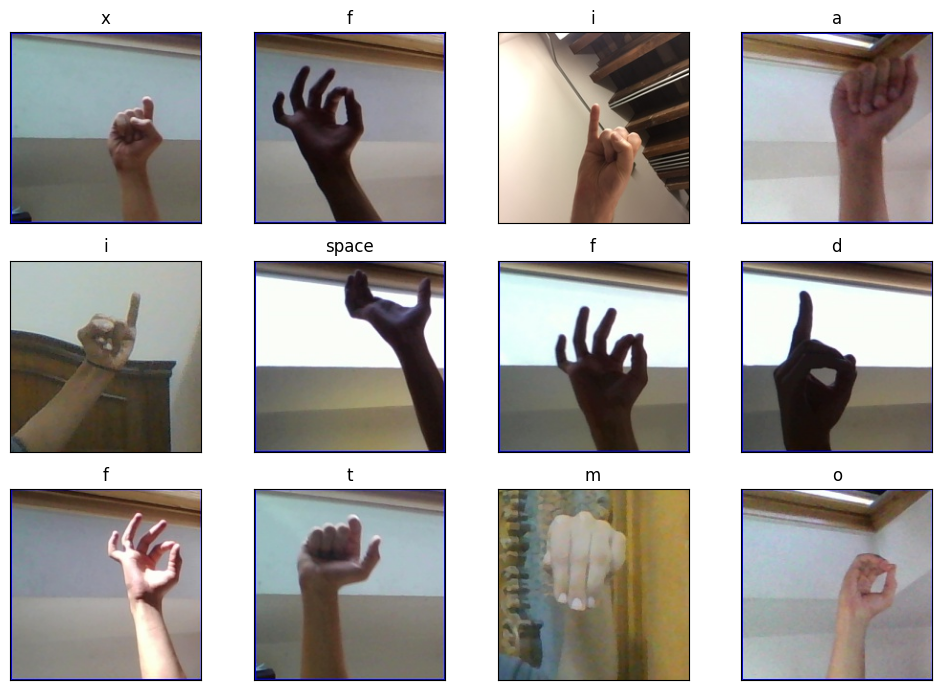

In [14]:
display_images_in_subplots(data=data_for_training[:12])

In [10]:
def plot_label_counts(data):
    """
    Plots the counts of each unique label in a given dataset.

    Args:
        data (pandas.DataFrame): The input dataset.

    Returns:
        None
    """

    plt.figure(figsize=(12, 6))
    counts = data.Label.value_counts()

    # Choose a more subdued color palette
    colors = sns.color_palette("flare", len(counts))

    sns.barplot(x=counts.index, y=counts, palette=colors)

    # Add a grid for better readability
    plt.grid(axis='y', linestyle='--')

    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=50)

In [28]:
import hashlib

image_hashes = {}
for image_file in data_for_training.FilePath:
    with open(image_file, 'rb') as f:
        hash_value = hashlib.sha256(f.read()).hexdigest()
        if hash_value in image_hashes:
            print("Duplicate image:", image_file)
        else:
            image_hashes[hash_value] = image_file

Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/J/J (2053).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/del/del (3432) (1).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/I/I (3449).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/R/R (1107).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/D/D471.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/del/del1545.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/D/D (2537).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/space/space1698.jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/M/M (2921).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabet_Dataset/asl_alphabet_train/F/F (3056).jpg
Duplicate image: drive/MyDrive/dataset/ASL_Alphabe

KeyboardInterrupt: 

<ipython-input-10-3a7169fa48b3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette=colors)


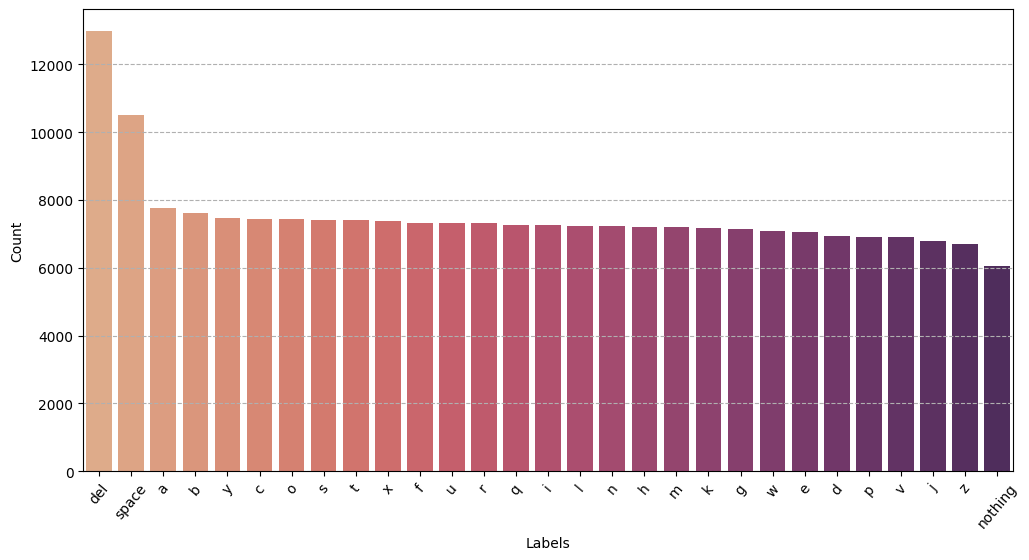

In [11]:
plot_label_counts(data_for_training)

<ipython-input-18-3a7169fa48b3>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts, palette=colors)


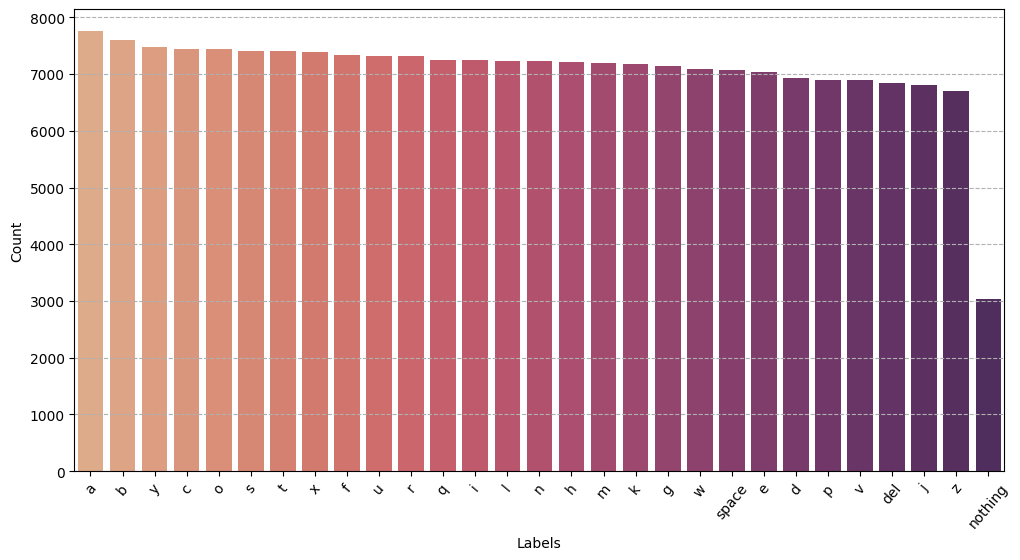

In [19]:
plot_label_counts(data_for_training)

## Creating our own Training & Validation Sets 📁

In [12]:
train_df, test_df = train_test_split(data_for_training, train_size=0.7, random_state=1)

## Preprocessing Data

In [23]:
def Generates_training_validation_test_data(pre, train, test):
    """
    Generates training, validation, and test data generators from Pandas DataFrames.

    Args:
        pre: A preprocessing function to apply to the images.
        train: A Pandas DataFrame containing the training data.
        test: A Pandas DataFrame containing the testing data.

    Returns:
        A tuple of training, validation, and test generators.
    """
    # Create ImageDataGenerators with the specified preprocessing function
    train_datagen = ImageDataGenerator(
        preprocessing_function=pre,
        validation_split=0.2
    )
    test_datagen = ImageDataGenerator(
        preprocessing_function=pre

    )

    # Generate training, validation, and test data from dataframes
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,

        fill_mode="nearest"

    )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='FilePath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,

        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,

        fill_mode="nearest"
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='FilePath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )

    return train_gen, valid_gen, test_gen

Comparison to tf.keras.preprocessing.image.ImageDataGenerator

The `preprocess_image` function is similar to the data generation process in `tf.keras.preprocessing.image.ImageDataGenerator`. However, there are some key differences:

* Single Image Processing: The preprocess_image function processes a single image at a time, while ImageDataGenerator can process multiple images in batches.
* Data Augmentation: ImageDataGenerator can apply various data augmentation techniques (e.g., rotation, flipping, zooming) to increase the diversity of the training data.
* Flowing Data: ImageDataGenerator can generate a flow of preprocessed images, which is often convenient for training models.


If you need to process multiple images or apply data augmentation, `ImageDataGenerator` would be a more suitable choice. However, for simple preprocessing tasks on individual images, the `preprocess_image` function provides a concise and efficient solution.

In [13]:
def preprocess_image(image_path, target_size=(224, 224)):
  """
  Preprocesses an image by reading it from a file, converting it to a tensor,
  normalizing it, resizing it, and optionally applying data augmentation techniques.

  Args:
      image_path (str): The path to the image file.
      target_size (tuple, optional): The desired size of the image (width, height).
          Defaults to (224, 224).
      data_augmentation (bool, optional): Whether to apply data augmentation
          techniques. Defaults to False.
          If True, consider using libraries like Albumentations for more
          flexibility, or create your own augmentation functions.

  Returns:
      tf.Tensor: The preprocessed image tensor.
  """

  # Read the image file and convert it to a tensor
  image = tf.io.read_file(image_path)

  # Decode the image based on its format (e.g., JPEG, PNG)
  image = tf.image.decode_image(image, channels=3)  # Assuming RGB

  # Normalize the image to the range [0, 1]
  image = tf.cast(image, tf.float32) / 255.0

  # Resize the image to the target size
  image = tf.image.resize(image, target_size)

  # Optionally apply data augmentation techniques
  #if data_augmentation:
      # Consider using libraries like Albumentations for flexibility
      # or create your own augmentation functions here

  return image

## Modeling

In [14]:
IMG_SIZE = 224

In [15]:
 # setup input shape to the model
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE,3]
 # setup the output shape of our model
OUTPUT_SHAPE = len(unique_sign)

 # setup model url from tensorflow hub
MODEL_URL ={'mobilenet':"https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4",
            'resnet_50':"https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"}

In [16]:
def create_custom_model(name_model):
    """
    Creates a custom image classification model based on a pre-trained model.

    Args:
        name_model: A function or class representing a pre-trained model.

    Returns:
        A tuple containing the compiled model and a list of callbacks.
    """

    pre_model = name_model(input_shape=(224,224, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(120, activation='relu')(pre_model.output)
    x = Dense(120, activation='relu')(x)
    outputs = Dense(29, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              mode='auto')]
    return model, my_callbacks

## Evaluating

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

def plot_and_evaluate(history, test_gen, train_gen, model, test_df):
    """
    Plots training and validation performance metrics and evaluates the model on test data.

    Args:
        history (History object): Training history object from model.fit().
        test_gen (ImageGenerator): Test data generator.
        train_gen (ImageGenerator): Training data generator.
        model (Model): Compiled Keras model.
        test_df (pandas.DataFrame): Test dataframe containing 'FilePath' and 'Label' columns.

    Returns:
        None
    """

    # Plot training and validation accuracy/loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Val'])
    plt.tight_layout()

    # Make predictions on test data
    predictions = model.predict(test_gen)
    predicted_classes = np.argmax(predictions, axis=1)  # Get class indices

    # Convert class indices to labels using training generator's class_indices
    class_labels = dict((v, k) for k, v in train_gen.class_indices.items())
    predicted_labels = [class_labels[k] for k in predicted_classes]

    # Print classification report
    print("Classification Report:")
    print(classification_report(test_df['Label'], predicted_labels))

    # Create confusion matrix
    confusion_matrix_ = confusion_matrix(test_df['Label'], predicted_labels)
    print("\nConfusion Matrix:")
    print(confusion_matrix_)

    # Display 6 pictures with their true and predicted labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        image = plt.imread(test_df.FilePath.iloc[i + 1])
        ax.imshow(image)
        ax.set_title(f"True: {test_df.Label.iloc[i + 1]}\nPredicted: {predicted_labels[i + 1]}")
    plt.tight_layout()
    plt.show()

In [18]:
def result_test(test, model_use):
  """
  Evaluates a model on a test dataset.

  Args:
    test: A test data generator.
    model_use: The compiled Keras model.

  Returns:
    A tuple containing the test loss and accuracy.
  """

  results = model_use.evaluate(test, verbose=0)

  print("    Test Loss: {:.5f}".format(results[0]))
  print("Test Accuracy: {:.2f}%".format(results[1] * 100))

  return results

## Saving a model

In [19]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/MyDrive/Colab Notebooks/American_Sign_Language/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

## Try and Fit Pretrained models

### ResNet

#### ResNet50

In [24]:
from keras._tf_keras.keras.applications.resnet import ResNet50
from keras._tf_keras.keras.applications.resnet50 import preprocess_input
RestNet50_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = Generates_training_validation_test_data(RestNet50_pre,train_df, test_df)

Found 121813 validated image filenames belonging to 29 classes.
Found 30453 validated image filenames belonging to 29 classes.
Found 65257 validated image filenames belonging to 29 classes.


In [21]:
ResNet50_model, callback=create_custom_model(ResNet50)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [25]:
valid_gen_RestNet

In [26]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=50,
    callbacks=callback
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  23/3807 ━━━━━━━━━━━━━━━━━━━━ 8:34:02 8s/step - accuracy: 0.0843 - loss: 3.3523

KeyboardInterrupt: 

In [ ]:
# Save our model trained on 1000 images
save_model(history, suffix="sign-language-resnet-Adam")

In [ ]:
history_ResNet=plot_and_evaluate(history,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [ ]:
result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

#### ResNet101

In [ ]:
!pip install keras_applications

In [ ]:
from keras_applications.resnet import ResNet101, preprocess_input
RestNet50_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = Generates_training_validation_test_data(RestNet50_pre,train_df, test_df)

### MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
MobileNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = Generates_training_validation_test_data(MobileNet_pre,train_df, test_df)

In [ ]:
MobileNet_model, callback=create_custom_model(MobileNet)

In [ ]:
history_MobileNet = MobileNet_model.fit(
    train_gen_MobileNet,
    validation_data=valid_gen_MobileNet,
    epochs=100,
    callbacks=callback
)

In [ ]:
history=plot_and_evaluate(history,test_gen_MobileNet,train_gen_MobileNet,MobileNet_model)

In [ ]:
result_MobileNet = result_test(test_gen_MobileNet,MobileNet_model)